<a href="https://colab.research.google.com/github/bronte999/CSC429_LCCDE/blob/main/CSC429_LCCDE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code adapted from the paper entitled "LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles" accepted in 2022 IEEE Global Communications Conference (GLOBECOM).
Authors: Li Yang (lyang339@uwo.ca), Abdallah Shami (Abdallah.Shami@uwo.ca), Gary Stevens, and Stephen de Rusett
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University, Ontario, Canada; S2E Technologies, St. Jacobs, Ontario, Canada

L. Yang, A. Shami, G. Stevens, and S. DeRusett, “LCCDE: A Decision-Based Ensemble Framework for Intrusion Detection in The Internet of Vehicles," in 2022 IEEE Global Communications Conference (GLOBECOM), 2022, pp. 1-6.

In [20]:
!pip install catboost
!pip install river

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import catboost as cbt
import xgboost as xgb
import time
from river import stream
from statistics import mode
from sklearn import preprocessing

In [23]:
! unzip /content/road.csv.zip -d data

Archive:  /content/road.csv.zip
replace data/road.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
df = pd.read_csv("/content/data/road.csv")

In [25]:
df

,Time,Id,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8,Label
0,1.270000e+09,2E1,00,00,00,00,00,00,00,04,Benign
1,1.270000e+09,354,1F,FF,40,00,00,04,09,00,Benign
2,1.270000e+09,5E1,89,3F,E0,0B,0A,00,00,80,Benign
3,1.270000e+09,162,00,08,00,03,EA,11,F4,CE,Benign
4,1.270000e+09,00E,20,52,D6,02,08,09,75,52,Benign
...,...,...,...,...,...,...,...,...,...,...,...
4095015,1.240000e+09,0C0,00,00,00,00,00,00,00,00,Benign
4095016,1.240000e+09,3E4,01,1C,00,00,05,00,00,00,Benign
4095017,1.240000e+09,65C,40,0D,A2,77,10,00,00,00,Benign
4095018,1.240000e+09,577,00,00,08,00,00,00,01,44,Benign


In [26]:
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['Label']= label_encoder.fit_transform(df['Label'])


In [27]:
df.Label.value_counts()

Label
1    3203917
0     828556
6      27028
5      23388
2      10986
3       1059
4         86
Name: count, dtype: int64

In [28]:
X = df.drop(['Label'],axis=1)
y = df['Label']

for col in X.columns:
    if X[col].dtype == object:  # Check if the column type is object (likely non-numeric)
        X[col] = X[col].apply(lambda x: int(x, 16))
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0) #shuffle=False

In [29]:
X

,Time,Id,Byte1,Byte2,Byte3,Byte4,Byte5,Byte6,Byte7,Byte8
0,1.270000e+09,737,0,0,0,0,0,0,0,4
1,1.270000e+09,852,31,255,64,0,0,4,9,0
2,1.270000e+09,1505,137,63,224,11,10,0,0,128
3,1.270000e+09,354,0,8,0,3,234,17,244,206
4,1.270000e+09,14,32,82,214,2,8,9,117,82
...,...,...,...,...,...,...,...,...,...,...
4095015,1.240000e+09,192,0,0,0,0,0,0,0,0
4095016,1.240000e+09,996,1,28,0,0,5,0,0,0
4095017,1.240000e+09,1628,64,13,162,119,16,0,0,0
4095018,1.240000e+09,1399,0,0,8,0,0,0,1,68


In [30]:
pd.Series(y_train).value_counts()

Label
1    2563261
0     662736
6      21579
5      18742
2       8783
3        844
4         71
Name: count, dtype: int64

In [33]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:1000,3:1000})

In [34]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [35]:
pd.Series(y_train).value_counts()

Label
1    2563261
0     662736
6      21579
5      18742
2       8783
3       1000
4       1000
Name: count, dtype: int64

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.592042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1928
[LightGBM] [Info] Number of data points in the train set: 3277101, number of used features: 10
[LightGBM] [Info] Start training from score -1.598338
[LightGBM] [Info] Start training from score -0.245679
[LightGBM] [Info] Start training from score -5.921896
[LightGBM] [Info] Start training from score -8.094714
[LightGBM] [Info] Start training from score -8.094714
[LightGBM] [Info] Start training from score -5.163947
[LightGBM] [Info] Start training from score -5.022994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

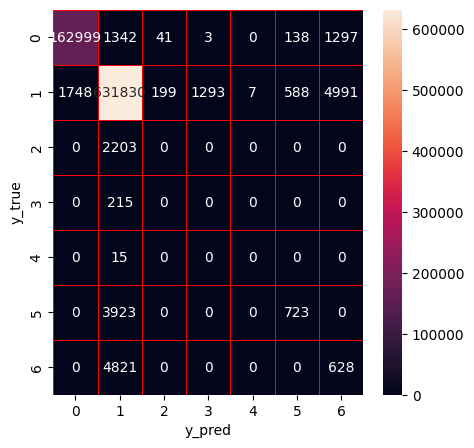

CPU times: user 3min 15s, sys: 998 ms, total: 3min 16s
Wall time: 3min 18s


In [36]:
%%time
# Train the LightGBM algorithm
import lightgbm as lgb
lg = lgb.LGBMClassifier()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of LightGBM: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of LightGBM: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of LightGBM: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of LightGBM: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of LightGBM for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
lg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    165820
           1       1.00      1.00      1.00    640656
           2       1.00      1.00      1.00      2203
           3       1.00      1.00      1.00       215
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00      4646
           6       1.00      1.00      1.00      5449

    accuracy                           1.00    819004
   macro avg       1.00      1.00      1.00    819004
weighted avg       1.00      1.00      1.00    819004

Accuracy of XGBoost: 0.9999987790047423
Precision of XGBoost: 0.9999987846574983
Recall of XGBoost: 0.9999987790047423
Average F1 of XGBoost: 0.9999987804207336
F1 of XGBoost for each type of attack: [1.         0.99999922 1.         0.99767981 1.         1.
 1.        ]


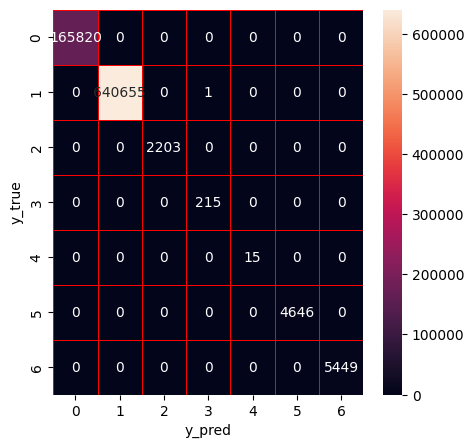

CPU times: user 4min 59s, sys: 980 ms, total: 5min
Wall time: 3min 4s


In [37]:
%%time
# Train the XGBoost algorithm
import xgboost as xgb
xg = xgb.XGBClassifier()

X_train_x = X_train.values
X_test_x = X_test.values

xg.fit(X_train_x, y_train)

y_pred = xg.predict(X_test_x)
print(classification_report(y_test,y_pred))
print("Accuracy of XGBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of XGBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of XGBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of XGBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of XGBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
xg_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
%%time
# Train the CatBoost algorithm
import catboost as cbt
cb = cbt.CatBoostClassifier(verbose=0,boosting_type='Plain')
#cb = cbt.CatBoostClassifier()

cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy of CatBoost: "+ str(accuracy_score(y_test, y_pred)))
print("Precision of CatBoost: "+ str(precision_score(y_test, y_pred, average='weighted')))
print("Recall of CatBoost: "+ str(recall_score(y_test, y_pred, average='weighted')))
print("Average F1 of CatBoost: "+ str(f1_score(y_test, y_pred, average='weighted')))
print("F1 of CatBoost for each type of attack: "+ str(f1_score(y_test, y_pred, average=None)))
cb_f1=f1_score(y_test, y_pred, average=None)

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
# Leading model list for each class
model=[]
for i in range(len(lg_f1)):
    if max(lg_f1[i],xg_f1[i],cb_f1[i]) == lg_f1[i]:
        model.append(lg)
    elif max(lg_f1[i],xg_f1[i],cb_f1[i]) == xg_f1[i]:
        model.append(xg)
    else:
        model.append(cb)

In [ ]:
model

In [ ]:
def LCCDE(X_test, y_test, m1, m2, m3):
    i = 0
    t = []
    m = []
    yt = []
    yp = []
    l = []
    pred_l = []
    pro_l = []

    # For each class (normal or a type of attack), find the leader model
    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred1 = m1.predict(xi2.reshape(1, -1))      # model 1 (LightGBM) makes a prediction on text sample xi
        y_pred1 = int(y_pred1[0])
        y_pred2 = m2.predict(xi2.reshape(1, -1))      # model 2 (XGBoost) makes a prediction on text sample xi
        y_pred2 = int(y_pred2[0])
        y_pred3 = m3.predict(xi2.reshape(1, -1))      # model 3 (Catboost) makes a prediction on text sample xi
        y_pred3 = int(y_pred3[0])

        p1 = m1.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 1
        p2 = m2.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 2
        p3 = m3.predict_proba(xi2.reshape(1, -1))     # The prediction probability (confidence) list of model 3

        # Find the highest prediction probability among all classes for each ML model
        y_pred_p1 = np.max(p1)
        y_pred_p2 = np.max(p2)
        y_pred_p3 = np.max(p3)

        if y_pred1 == y_pred2 == y_pred3: # If the predicted classes of all the three models are the same
            y_pred = y_pred1 # Use this predicted class as the final predicted class

        elif y_pred1 != y_pred2 != y_pred3: # If the predicted classes of all the three models are different
            # For each prediction model, check if the predicted class’s original ML model is the same as its leader model
            if model[y_pred1]==m1: # If they are the same and the leading model is model 1 (LightGBM)
                l.append(m1)
                pred_l.append(y_pred1) # Save the predicted class
                pro_l.append(y_pred_p1) # Save the confidence

            if model[y_pred2]==m2: # If they are the same and the leading model is model 2 (XGBoost)
                l.append(m2)
                pred_l.append(y_pred2)
                pro_l.append(y_pred_p2)

            if model[y_pred3]==m3: # If they are the same and the leading model is model 3 (CatBoost)
                l.append(m3)
                pred_l.append(y_pred3)
                pro_l.append(y_pred_p3)

            if len(l)==0: # Avoid empty probability list
                pro_l=[y_pred_p1,y_pred_p2,y_pred_p3]

            elif len(l)==1: # If only one pair of the original model and the leader model for each predicted class is the same
                y_pred=pred_l[0] # Use the predicted class of the leader model as the final prediction class

            else: # If no pair or multiple pairs of the original prediction model and the leader model for each predicted class are the same
                max_p = max(pro_l) # Find the highest confidence

                # Use the predicted class with the highest confidence as the final prediction class
                if max_p == y_pred_p1:
                    y_pred = y_pred1
                elif max_p == y_pred_p2:
                    y_pred = y_pred2
                else:
                    y_pred = y_pred3

        else: # If two predicted classes are the same and the other one is different
            n = mode([y_pred1,y_pred2,y_pred3]) # Find the predicted class with the majority vote
            y_pred = model[n].predict(xi2.reshape(1, -1)) # Use the predicted class of the leader model as the final prediction class
            y_pred = int(y_pred[0])

        yt.append(yi)
        yp.append(y_pred) # Save the predicted classes for all tested samples
    return yt, yp

In [ ]:
%%time
# Implementing LCCDE
yt, yp = LCCDE(X_test, y_test, m1 = lg, m2 = xg, m3 = cb)

In [ ]:
# The performance of the proposed lCCDE model
print("Accuracy of LCCDE: "+ str(accuracy_score(yt, yp)))
print("Precision of LCCDE: "+ str(precision_score(yt, yp, average='weighted')))
print("Recall of LCCDE: "+ str(recall_score(yt, yp, average='weighted')))
print("Average F1 of LCCDE: "+ str(f1_score(yt, yp, average='weighted')))
print("F1 of LCCDE for each type of attack: "+ str(f1_score(yt, yp, average=None)))

In [ ]:
# Comparison: The F1-scores for each base model
print("F1 of LightGBM for each type of attack: "+ str(lg_f1))
print("F1 of XGBoost for each type of attack: "+ str(xg_f1))
print("F1 of CatBoost for each type of attack: "+ str(cb_f1))
